In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from helpers import *

# pandas formatting
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', 200)

In [2]:
# import tables
documents = sql("SELECT * FROM csas2_document")
tracking = sql("SELECT * FROM csas2_documenttracking")

In [3]:
status_columns = [
    'submission_date',
    'date_chair_sent',
    'date_chair_appr',
    'date_coordinator_sent',
    'date_coordinator_appr',
    'date_section_head_sent',
    'date_section_head_appr',
    'date_division_manager_sent',
    'date_division_manager_appr',
    'date_director_sent',
    'date_director_appr',
    'date_doc_submitted',
    'date_proof_author_sent',
    'date_proof_author_approved',
    'actual_posting_date',
    # 'updated_posting_date',  # IGNORE updated_posting_date
]

translation_status_columns = [
    'date_translation_sent',
    'date_returned',
    'translation_review_date',
]

In [105]:
def time_matrix(dataframe, col_lst, all_stats=False, quantile=0.5):
    df_temp = dataframe[col_lst].apply(pd.to_datetime, errors='coerce')
    matrix = pd.DataFrame(index=col_lst, columns=col_lst)
    
    for i, from_step in enumerate(col_lst):
        for j, to_step in enumerate(col_lst):
            if i < j:
                if all_stats:
                    matrix.loc[from_step, to_step] = (
                        round((df_temp[to_step] - df_temp[from_step]).dt.days.mean(), 1),
                        round((df_temp[to_step] - df_temp[from_step]).dt.days.quantile([0.025, 0.16, 0.5, 0.84, 0.975]), 1),
                    )
                else:
                    matrix.loc[from_step, to_step] = round((df_temp[to_step] - df_temp[from_step]).dt.days.quantile(quantile), 1)
                
    return matrix.apply(pd.to_numeric, errors='coerce')


In [106]:
submission_steps = ['submission_date', 'date_doc_submitted', 'actual_posting_date']
display(time_matrix(tracking, status_columns, True).T)
display(time_matrix(tracking, translation_status_columns, True).T)
display(time_matrix(tracking, submission_steps, True).T)

,submission_date,date_chair_sent,date_chair_appr,date_coordinator_sent,date_coordinator_appr,date_section_head_sent,date_section_head_appr,date_division_manager_sent,date_division_manager_appr,date_director_sent,date_director_appr,date_doc_submitted,date_proof_author_sent,date_proof_author_approved,actual_posting_date
submission_date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_chair_sent,"(10.4, [-15.4, 0.0, 0.0, 17.0, 164.6])",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_chair_appr,"(11.3, [-55.1, 0.0, 3.0, 34.6, 211.9])","(20.2, [0.0, 0.0, 2.0, 20.8, 127.0])",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_coordinator_sent,"(33.0, [0.0, 0.0, 3.0, 51.2, 307.8])","(19.7, [-1.3, 0.0, 1.0, 24.7, 128.5])","(15.1, [-66.6, -3.0, 0.0, 12.0, 247.7])",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_coordinator_appr,"(51.6, [0.0, 1.0, 20.0, 92.1, 393.4])","(42.7, [0.0, 0.9, 14.5, 75.2, 203.4])","(35.5, [-10.9, 0.0, 6.5, 54.4, 322.2])","(20.6, [0.0, 0.0, 3.0, 34.2, 142.1])",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_section_head_sent,"(67.8, [-1.0, 28.2, 46.0, 91.6, 264.9])","(62.9, [0.4, 10.8, 43.0, 83.8, 277.8])","(21.6, [-28.6, 0.0, 9.0, 52.9, 89.6])","(62.1, [0.0, 3.2, 43.0, 93.2, 279.8])","(12.1, [-40.0, -7.9, 0.0, 43.9, 83.6])",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_section_head_appr,"(66.5, [4.0, 23.7, 49.0, 91.0, 236.7])","(68.2, [3.4, 19.9, 48.5, 86.0, 273.6])","(40.8, [-12.1, 0.0, 15.0, 65.4, 231.1])","(62.5, [0.0, 9.0, 48.0, 90.0, 251.5])","(14.9, [-27.0, -1.0, 0.0, 42.0, 87.6])","(7.5, [0.0, 0.0, 2.0, 9.9, 43.0])",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_division_manager_sent,"(57.8, [0.0, 2.0, 26.0, 101.0, 368.6])","(41.6, [0.0, 1.0, 19.0, 70.0, 206.5])","(39.2, [-16.8, 0.0, 7.5, 69.8, 215.7])","(33.6, [0.0, 0.0, 9.0, 59.2, 193.5])","(6.2, [-28.0, 0.0, 0.0, 4.1, 80.2])","(5.6, [0.0, 0.0, 0.0, 6.8, 39.3])","(-0.7, [-22.2, -4.9, 0.0, 0.0, 24.7])",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_division_manager_appr,"(64.1, [1.0, 7.0, 33.0, 105.3, 401.0])","(47.2, [1.0, 5.0, 25.5, 85.0, 184.6])","(48.4, [-3.0, 3.0, 16.5, 81.5, 336.1])","(39.9, [0.0, 3.0, 20.0, 81.2, 188.0])","(13.3, [-8.4, 0.0, 5.0, 22.7, 96.1])","(11.4, [0.0, 0.0, 3.0, 29.4, 52.2])","(4.7, [-1.4, 0.0, 0.0, 6.6, 41.2])","(7.3, [0.0, 0.0, 3.0, 12.7, 35.0])",NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_director_sent,"(64.6, [1.0, 8.0, 29.0, 85.5, 420.2])","(45.8, [1.0, 6.0, 27.0, 75.9, 234.3])","(51.9, [0.0, 3.0, 20.0, 66.2, 449.5])","(37.3, [0.0, 1.0, 14.0, 51.0, 145.5])","(27.9, [-0.8, 0.0, 4.0, 27.8, 132.5])","(12.8, [0.0, 0.0, 4.5, 33.5, 50.6])","(4.1, [-5.4, -0.6, 0.0, 5.9, 38.4])","(8.6, [0.0, 0.0, 4.0, 16.7, 37.3])","(2.7, [-8.0, 0.0, 0.0, 4.7, 28.4])",NaN,NaN,NaN,NaN,NaN,NaN


,date_translation_sent,date_returned,translation_review_date
date_translation_sent,NaN,NaN,NaN
date_returned,"(23.7, [6.0, 13.0, 21.0, 34.0, 91.0])",NaN,NaN
translation_review_date,"(55.4, [8.2, 16.8, 37.0, 97.2, 190.8])","(40.7, [0.0, 2.0, 12.0, 80.5, 307.8])",NaN


,submission_date,date_doc_submitted,actual_posting_date
submission_date,NaN,NaN,NaN
date_doc_submitted,"(118.4, [7.0, 29.0, 72.0, 229.9, 457.3])",NaN,NaN
actual_posting_date,"(154.4, [34.6, 63.0, 106.5, 260.8, 490.7])","(-32.6, [6.0, 22.0, 34.0, 69.0, 227.0])",NaN


In [121]:
def plot_heatmap(dataframe, col_lst, quantile=0.5, figsize=(8, 8)):
    plt.figure(figsize=figsize)
    
    matrix = time_matrix(dataframe, col_lst, quantile=quantile).dropna(how='all').fillna(-99)
    annot = matrix.map(lambda x: f"{int(x)}" if x >= 0 else "")
    
    fig = sns.heatmap(
        matrix, 
        annot=annot, 
        cmap='Blues',
        vmin=-10,
        vmax=100,
        fmt='', 
        cbar=False
    )
    
    fig.xaxis.set_ticks_position('top')
    fig.tick_params(axis='x', rotation=90, length=0)
    fig.tick_params(axis='x', rotation=90)
    
    plt.show()
    

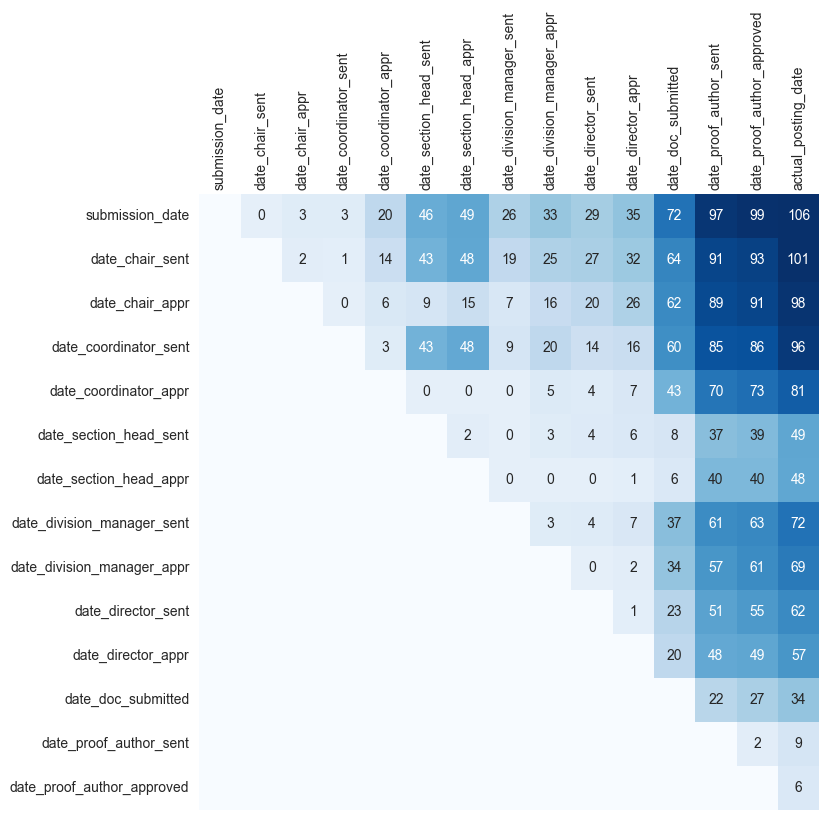

In [122]:
plot_heatmap(tracking, status_columns)

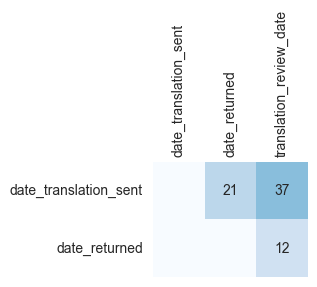

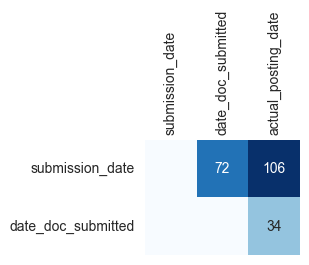

In [124]:
plot_heatmap(tracking, translation_status_columns, figsize=(2,1.5))
plot_heatmap(tracking, submission_steps, figsize=(2,1.5))

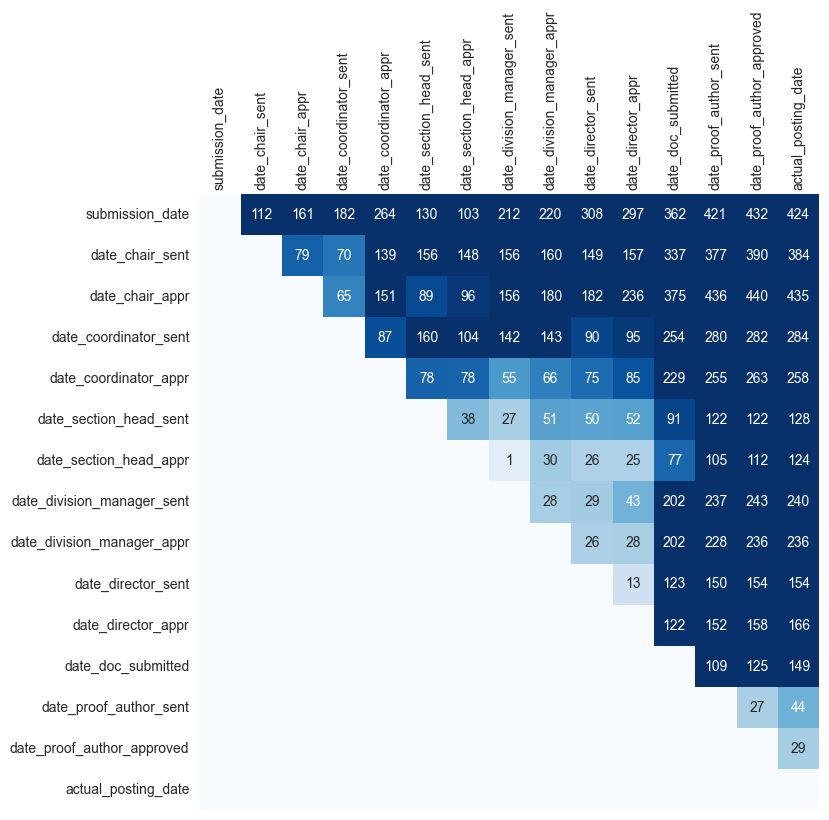

In [111]:
plot_heatmap(tracking, status_columns, quantile=0.95)

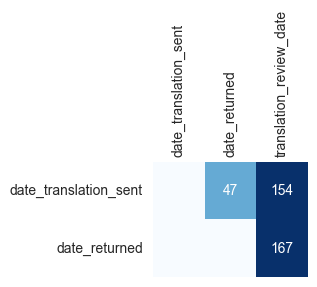

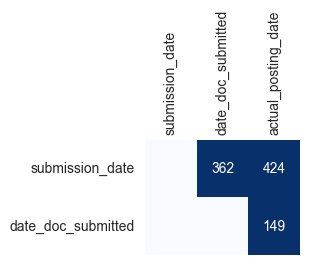

In [125]:
plot_heatmap(tracking, translation_status_columns, figsize=(2,1.5), quantile=0.95)
plot_heatmap(tracking, submission_steps, figsize=(2,1.5), quantile=0.95)